In [ ]:
1. Project Overview
Include a brief project summary at the beginning:

Objective: To build a web scraper that extracts song lyrics for a specified artist, with data saved in a structured format.
Output: A CSV file containing information on songs, including artist name, album, song title, song URL, lyrics, and word count

In [5]:
"""
Web Scraper for Song Lyrics

This script scrapes song lyrics for a specified artist from songlyrics.com.
The data includes artist name, song title, song URL, lyrics, and word count.
It visualizes the word count distribution in a histogram.
"""

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

2. Modularize the Code
Separate each logical task into individual functions to improve readability and reusability. This also makes testing and debugging easier.

A. Function to Build URL for Artist
This function generates the URL for the artist’s page, keeping it modular and flexible for different artists.

In [7]:
def build_artist_url(artist):
    """Generates the URL for the given artist's song page."""
    return f"https://www.songlyrics.com/{artist.replace(' ', '-')}-lyrics/"

B. Function to Get Artist Data (Songs and Links)
Improve error handling by raising exceptions and providing clearer messages. Use a DataFrame directly, as this makes data manipulation easier in the later steps.

In [8]:
def get_artist_data(artist):
    """Fetches song titles and links for a specified artist from songlyrics.com."""
    url = build_artist_url(artist)
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for {artist}. Status code: {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    table = soup.find("table", class_="tracklist")
    if not table:
        print(f"No songs found for {artist}.")
        return None
    
    artist_data = []
    rows = table.find_all("tr")[1:11]  # Fetching only the first 10 rows to avoid rate limiting
    for row in rows:
        cells = row.find_all("td")
        if cells:
            song_info = cells[1].find("a")
            if song_info:
                song_title = song_info.text.strip()
                song_link = song_info["href"]
                artist_data.append({"artist": artist, "song_title": song_title, "song_link": song_link})
    
    return pd.DataFrame(artist_data)


C. Function to Get Lyrics and Process Data
The function get_lyrics fetches lyrics from a given song URL. process_artist calls both get_artist_data and get_lyrics, creating a DataFrame with lyrics data and word counts.

In [9]:
def get_lyrics(song_url):
    """Fetches lyrics from a song URL on songlyrics.com."""
    response = requests.get(song_url)
    if response.status_code != 200:
        print(f"Failed to retrieve lyrics for {song_url}. Status code: {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")
    lyrics_div = soup.find("p", class_="songLyricsV14")
    return lyrics_div.get_text(separator="\n").strip() if lyrics_div else ""

def process_artist(artist):
    """Processes all songs for an artist to collect title, link, lyrics, and word count."""
    artist_data = get_artist_data(artist)
    if artist_data is None:
        return None
    
    all_lyrics = []
    for _, row in artist_data.iterrows():
        lyrics = get_lyrics(row['song_link'])
        if lyrics:
            word_count = len(lyrics.split())
            all_lyrics.append((row['artist'], row['song_title'], row['song_link'], lyrics, word_count))
    
    return pd.DataFrame(all_lyrics, columns=['artist', 'song_title', 'song_link', 'lyrics', 'word_count'])


D. Example Implementation
Provide an example with error handling to avoid interruptions if the site blocks requests.

In [11]:
artist = 'Beyonce'
try:
    beyonce_df = process_artist(artist)
    if beyonce_df is not None:
        beyonce_df.to_csv(f'{artist}_lyrics_data.csv', index=False)
        print(beyonce_df.head())
except Exception as e:
    print(f"Error processing data for {artist}: {e}")


    artist                  song_title  \
0  Beyonce                Naughty Girl   
1  Beyonce             Me Myself And I   
2  Beyonce       Dangerously in Love 2   
3  Beyonce                 Trust In Me   
4  Beyonce  Baby Boy (feat. Sean Paul)   

                                           song_link  \
0  https://www.songlyrics.com/beyonce/naughty-gir...   
1  https://www.songlyrics.com/beyonce/me-myself-a...   
2  https://www.songlyrics.com/beyonce/dangerously...   
3  https://www.songlyrics.com/beyonce/trust-in-me...   
4  https://www.songlyrics.com/beyonce/baby-boy-fe...   

                                              lyrics  word_count  
0  I'm feelin' sexy\n\r\nI wanna hear you say my ...         313  
1  All the ladies, if you feel me\n\r\nHelp me si...         644  
2  Baby I love you\n\r\nYou are my life\n\r\nMy h...         264  
3  Trust in me in all you do, have the faith I ha...         205  
4  (Sean Paul:)\n\r\nCertified quality\n\r\nA dat...         626  


3. Visualization: Word Count Distribution
Enhance the histogram visualization with custom colors and grid lines for clarity.

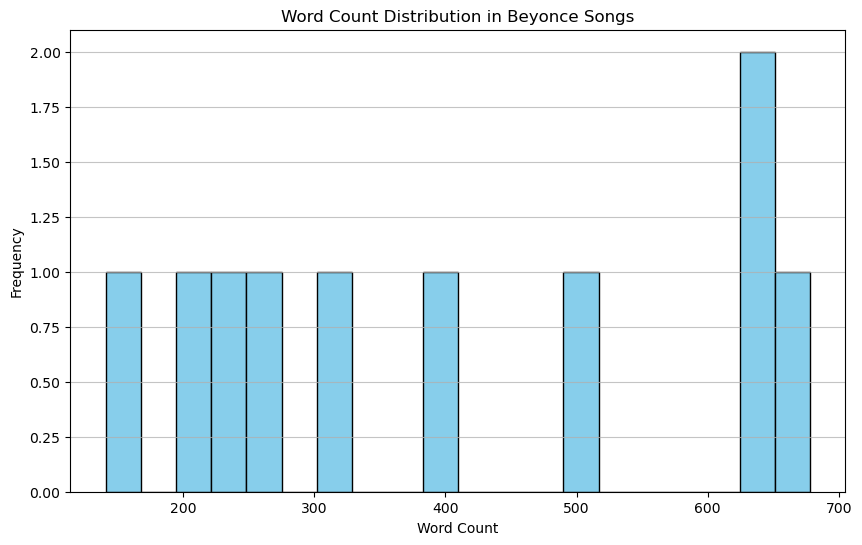

In [12]:
def plot_word_distribution(df, artist):
    """Plots a histogram of word counts in songs for the given artist."""
    plt.figure(figsize=(10, 6))
    plt.hist(df['word_count'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Word Count Distribution in {artist} Songs')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Call the plot function
if beyonce_df is not None:
    plot_word_distribution(beyonce_df, artist)
